## Assignment 2 - Due 10pm April 11th 2022
By Sam Archie (53743534/sar173)

In [9]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import salem
import requests
import logging
from rasterio.features import rasterize
from tqdm import tqdm_notebook
from pathlib import Path
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from warnings import filterwarnings
from affine import Affine
filterwarnings("ignore") # Ignore the warnings arising from the tqdm library not being the latest version and using xarray ufuncs squareroot

### Task 1: Monthly and annual mean wind speeds
Look at Table 1 from the Canterbury region report and reproduce the equivalent outputs but from the WRF data you have access to. Use the entire 20-year temporal period. Be creative in how you present the table within the notebook environment.

Display what the end goal of this task is, by displaying the Table from the NIWA Canterbury report

In [59]:
df = pd.DataFrame([['Le Bons Bay', 23.0, 22.2, 23.0, 22.1, 22.2, 23.7, 21.1, 22.0, 24.3, 24.1, 23.7, 23.5, 22.9],
                    ['Kaikoura', 16.3, 15.8, 15.9, 15.2, 15.7, 16.4, 15.3, 16.3, 15.8, 16.9, 17.1, 16.7, 16.1],
                    ['Lyttelton Harbour', 18.1, 17.2, 16.4, 14.0, 14.1, 13.6, 13.1, 14.8, 16.0, 17.4, 17.7, 18.3, 15.9],
                    ['Christchurch', 17.3, 16.3, 14.9, 13.0, 12.2, 11.1, 11.4, 12.8, 14.4, 15.9, 16.6, 17.1, 14.4],
                    ['Lake Tekapo', 15.9, 13.0, 13.0, 11.6, 11.3, 10.7, 11.3, 11.5, 15.3, 15.9, 16.3, 14.8, 13.4],
                    ['Darfield', 13.7, 13.4, 13.3, 11.6, 11.7, 12.1, 11.3, 12.0, 14.3, 14.4, 14.6, 14.5, 13.1],
                    ['Rangiora', 11.6, 10.7, 10.0, 8.8, 9.3, 9.1, 8.7, 10.0, 10.9, 11.4, 11.4, 11.8, 10.3],
                    ['Pukaki Aerodrome', 13.4, 10.7, 10.3, 8.9, 8.5, 6.6, 7.7, 8.3, 11.5, 12.4, 12.7, 12.5, 10.3],
                    ['Winchmore', 11.4, 10.3, 10.2, 9.0, 9.0, 8.2, 8.4, 9.5, 11.5, 11.7, 12.0, 11.7, 10.3],
                    ['Fairlie', 11.0, 8.4, 8.8, 8.3, 9.9, 9.4, 10.4, 9.2, 11.1, 11.0, 10.5, 9.6, 9.8],
                    ['Mt Cook Village', 12.4, 10.3, 10.0, 8.2, 8.1, 7.3, 6.8, 7.2, 10.7, 11.5, 11.9, 11.1, 9.6],
                    ['Timaru', 10.4, 9.7, 9.4, 8.3, 8.2, 8.4, 8.2, 8.6, 9.7, 10.9, 10.8, 10.5, 9.4],
                    ['Culverden', 10.2, 8.1, 7.9, 6.8, 6.4, 6.0, 6.3, 7.0, 8.6, 9.5, 9.4, 9.1, 8.0],
                    ['Hanmer Springs', 7.7, 6.9, 6.8, 5.7, 5.9, 5.5, 5.2, 6.0, 8.1, 8.5, 8.4, 8.2, 6.9]],
                    columns=['Location', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Ann']).set_index("Location")
df.columns.name = df.index.name
df.index.name = None
print('Table 1. Mean monthly and annual wind speed (km/hr) for selected Canterbury locations, from all available data. Replicated from "The Climate and Weather of Canterbury" by NIWA: https://niwa.co.nz/sites/niwa.co.nz/files/Canterbury%20climate%20FINAL%20WEB.pdf')
df

Table 1. Mean monthly and annual wind speed (km/hr) for selected Canterbury locations, from all available data. Replicated from "The Climate and Weather of Canterbury" by NIWA: https://niwa.co.nz/sites/niwa.co.nz/files/Canterbury%20climate%20FINAL%20WEB.pdf


Location,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ann
Le Bons Bay,23.0,22.2,23.0,22.1,22.2,23.7,21.1,22.0,24.3,24.1,23.7,23.5,22.9
Kaikoura,16.3,15.8,15.9,15.2,15.7,16.4,15.3,16.3,15.8,16.9,17.1,16.7,16.1
Lyttelton Harbour,18.1,17.2,16.4,14.0,14.1,13.6,13.1,14.8,16.0,17.4,17.7,18.3,15.9
Christchurch,17.3,16.3,14.9,13.0,12.2,11.1,11.4,12.8,14.4,15.9,16.6,17.1,14.4
Lake Tekapo,15.9,13.0,13.0,11.6,11.3,10.7,11.3,11.5,15.3,15.9,16.3,14.8,13.4
Darfield,13.7,13.4,13.3,11.6,11.7,12.1,11.3,12.0,14.3,14.4,14.6,14.5,13.1
Rangiora,11.6,10.7,10.0,8.8,9.3,9.1,8.7,10.0,10.9,11.4,11.4,11.8,10.3
Pukaki Aerodrome,13.4,10.7,10.3,8.9,8.5,6.6,7.7,8.3,11.5,12.4,12.7,12.5,10.3
Winchmore,11.4,10.3,10.2,9.0,9.0,8.2,8.4,9.5,11.5,11.7,12.0,11.7,10.3
Fairlie,11.0,8.4,8.8,8.3,9.9,9.4,10.4,9.2,11.1,11.0,10.5,9.6,9.8


Define the name, lat and lon of each location to be analysed. Originally was created using the geocoder library, but the accuracy for some of the places was not great (Mt Cook Village directed to Mount Cook for example) hence had to manually define places using Google Maps.

In [2]:
locations = pd.DataFrame([
    ["Le Bons Bay", -43.741223, 173.0914964], 
    ["Kaikoura", -42.4006991, 173.681138],
    ["Lyttelton Harbour", -43.6033466, 172.7201783], 
    ["Christchurch", -43.48763, 172.5352086], 
    ["Lake Tekapo", -44.0074527, 170.4744565], 
    ["Darfield", -43.4898369, 172.1090721], 
    ["Rangiora", -43.303333, 172.595133], 
    ["Pukaki Aerodrome", -44.2403261, 170.1190804], 
    ["Winchmore", -43.809067, 171.6935106], 
    ["Fairlie", -44.0964024, 170.8288013], 
    ["Mt Cook Village", -43.73751, 170.1007102], 
    ["Timaru", -44.397794, 171.252322], 
    ["Culverden", -42.7724716, 172.8462487], 
    ["Hamner Springs", -42.5227201, 172.8266887]
    ], columns = ["Location", "Lat", "Lon"])

To save on computational time, the U and V components are chunked. The windspeed can be determined, as well as the monthly averages which are then computed.

In [3]:
def calulate_windspeeds(u_glob_fps, v_glob_fps, chunks, time_resample):
    """
    Calculate and return the average wind velocities for a given month across each location at a given height from the ground. To be flexible, this function only requires two optional parameters which are: the year-month-day-time string and the height (from the ground). The defaults are set for January 2020 at 10m height, so, if you wish to analyse a different month or height, then it can be passed in.
    """
    u_dataset = xr.open_mfdataset(u_glob_fps, chunks=chunks, parallel=True).isel(height=0)
    v_dataset = xr.open_mfdataset(v_glob_fps, chunks=chunks, parallel=True).isel(height=0)
    windspeeds = xr.ufuncs.sqrt(u_dataset.U**2 + v_dataset.V**2) * 3.6 # Multiplied by 3.6 to convert from m/s to km/hr
    if time_resample != None:
        windspeeds = windspeeds.resample(time=time_resample).mean(dim="time")
    return windspeeds

Selected parameters are passed to the function above, so that we can calculate the monthly windspeeds for all of NZ to reduce run-time

In [36]:
with Client(n_workers=2, threads_per_worker=2, memory_limit='4GB', dashboard_address=45803, local_directory=str(Path.home()), silence_logs=logging.ERROR) as client:
    windspeeds = calulate_windspeeds("/mnt/data/MetService_WRF/U_20*", "/mnt/data/MetService_WRF/V_20*", chunks={"height":1, "time":100}, height=10, time_resample="1M").compute().groupby("time.month").mean()

Now that we have an xarray of monthly averages for each location, the best way to display this data is to collate it into one DataFrame. The below code cell (1) collects all the averages for each location, (2) calculates the annual average and (3) makes the table look pretty and professional.

In [60]:
average_windspeeds = pd.DataFrame() # Empty DataFrame to add each location to
for location in locations.to_dict("records"):
    # Find the monthly averages for this location by choosing nearest data point
    result = windspeeds.sel(lat=location["Lat"], lon=location["Lon"], method="nearest")
    # Format it into a DataFrame and add it to the bottom of the overall DataFrame
    average_windspeeds = pd.concat([average_windspeeds, result.to_dataframe(name=location["Location"])[[location["Location"]]].T])
    
# Calculate the annual average and add it to a new column
average_windspeeds["Ann"] = average_windspeeds.mean(axis=1)

# Format the DataFrame to make it look pretty
average_windspeeds = average_windspeeds.round(1)
average_windspeeds.columns.set_names("Location", inplace=True)
average_windspeeds.rename(columns={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}, inplace=True)
print('Mean monthly and annual wind speed (km/hr) for selected Canterbury locations, from all available Metservice WRF data after 2000')
average_windspeeds

Mean monthly and annual wind speed (km/hr) for selected Canterbury locations, from all available Metservice WRF data after 2000


Location,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ann
Le Bons Bay,15.7,15.1,14.7,14.1,14.7,15.1,14.7,14.3,15.6,15.8,15.5,15.3,15.0
Kaikoura,10.8,10.1,9.8,9.1,9.7,10.2,10.0,9.4,10.4,10.8,10.9,10.6,10.1
Lyttelton Harbour,15.0,14.2,13.3,11.9,11.9,11.6,11.1,11.6,12.5,13.9,14.2,14.9,13.0
Christchurch,14.2,12.8,11.7,10.2,10.0,9.8,9.5,10.0,11.9,12.9,13.2,13.9,11.7
Lake Tekapo,12.4,10.9,9.9,9.0,9.6,9.0,8.8,8.8,11.9,12.5,13.1,12.5,10.7
Darfield,16.0,15.1,14.6,13.5,14.0,13.8,13.7,13.6,15.8,15.8,15.6,15.6,14.8
Rangiora,14.1,12.7,11.9,10.5,10.9,10.8,10.7,10.7,12.5,13.2,13.7,13.7,12.1
Pukaki Aerodrome,9.7,8.3,7.4,6.7,7.1,6.6,6.3,6.2,8.6,9.3,10.0,9.6,8.0
Winchmore,11.5,10.4,9.8,9.3,9.9,9.6,9.7,9.7,11.3,11.6,11.6,11.6,10.5
Fairlie,10.4,9.0,8.6,7.8,8.3,8.2,8.1,7.8,9.6,10.5,10.7,10.1,9.1


### Task 2: Violin plots
Construct one violin plot for each of the town/city centres of Table 1. The violin plot will use the hourly data outputs and not the monthly/annual means.

The process for this task is to:
1. calculate the windspeeds all over NZ (and don't resample)
2. select the hourly windspeeds for each location and compute them
3. create a violin plot for each locations hourly data

In [7]:
hourly_windspeeds_at_each_location = {} # Empty dictionary to add the hourly data for each location to
# Use Dask distributed client to process tasks in parallel
with Client(n_workers=2, threads_per_worker=2, memory_limit='4GB', dashboard_address=45803, local_directory=str(Path.home()), silence_logs=logging.ERROR) as client:
    # Calculate the windspeeds for all of NZ and don't resample the time
    hourly_windspeeds = calulate_windspeeds("/mnt/data/MetService_WRF/U_20*", "/mnt/data/MetService_WRF/V_20*", chunks={"height":1, "time":100}, height=10, time_resample=None)
    # Loop through each location and...
    for location in tqdm_notebook(locations.to_dict("records"), "Selecting windspeeds at each location", total=len(locations), dynamic_ncols=True, leave=True):
        # Select the data at the location and compute them. Roughly 35 mins for each location
        location_hourly_windspeeds = hourly_windspeeds.sel(lat=location["Lat"], lon=location["Lon"], method="nearest").compute().values
        # And save them to the overall dictionary. Also, remove the NaN values from the array so the violin plot does not screw up
        hourly_windspeeds_at_each_location[location["Location"]] = location_hourly_windspeeds[~np.isnan(location_hourly_windspeeds)]

Selecting windspeeds at each location:   0%|          | 0/14 [00:00<?, ?it/s]

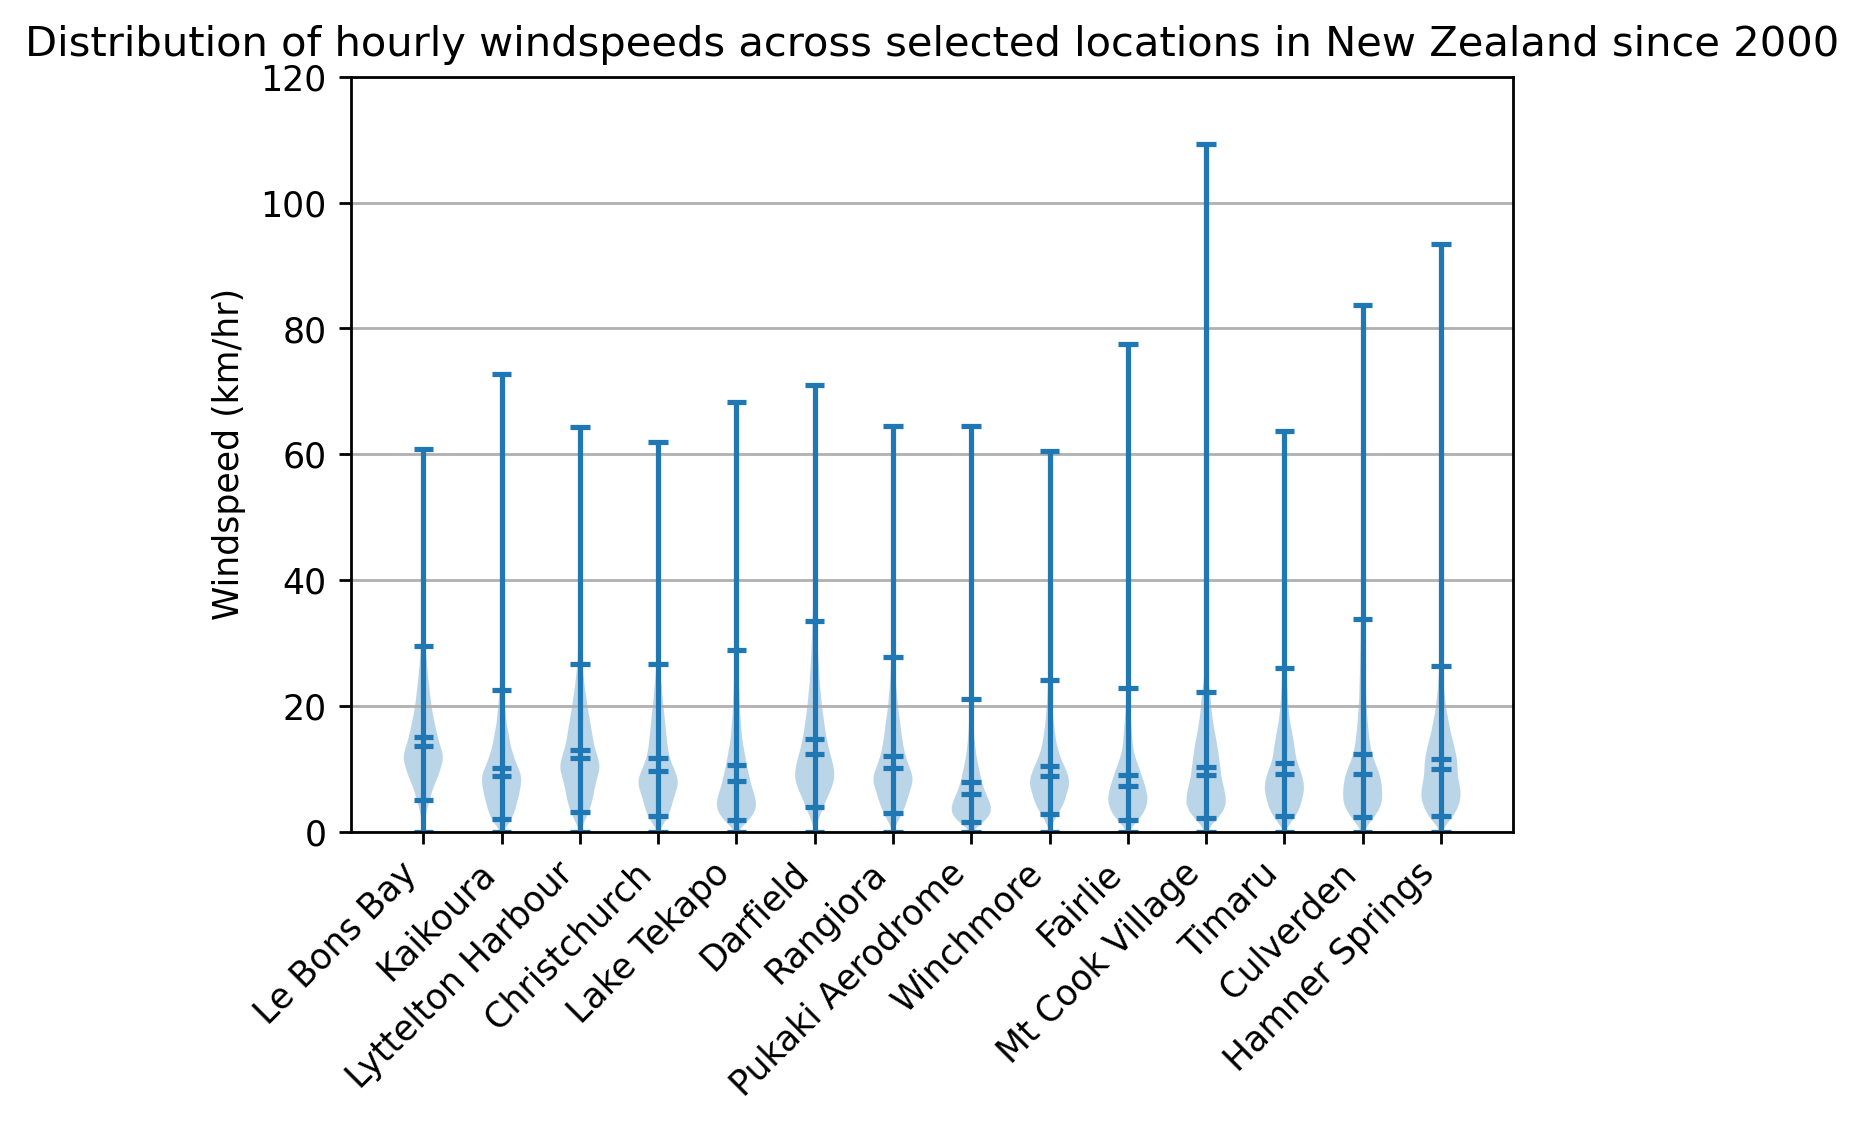

In [68]:
fig, ax = plt.subplots() # Create the figure and axis
# Plot all of the cities data as a violin plot, which include lines for the 5th and 95th percentiles as well (as we can actually see what the extrema points are!)
_ = ax.violinplot(hourly_windspeeds_at_each_location.values(), vert=True, showmeans=True, showextrema=True, showmedians=True, quantiles=[[0.05, 0.95]] * len(locations))
# Format the figure so it looks professional and nice
plt.xticks(ticks=range(1, len(locations) + 1), labels=hourly_windspeeds_at_each_location.keys(), rotation=45, ha="right")
plt.ylabel("Windspeed (km/hr)")
ax.set_ylim(0, 120)
ax.grid(axis="y")
ax.set_title("Distribution of hourly windspeeds across selected locations in New Zealand since 2000")
fig.set_dpi(250)

### Task 3: Median annual average temperature
Reproduce the median annual average temperature for both the New Zealand national scale and the Canterbury regional scale

The method to calculating the median annual average temperture is simple. The ETA of the process is 20 mins and follows:
1. open the datasets via chunking and only keep the ground height (10 metres) data
2. upsample the data from hourly to yearly by computing the mean of each year (it is assumed that the word 'annual average' refers to calculating the mean of each year)
3. applying a mask to find the coastline of New Zealand
4. computing the median of each year's entry for all of NZ

In [2]:
# Use Dask distributed client to process tasks in parallel
with Client(n_workers=2, threads_per_worker=2, memory_limit='4GB', dashboard_address=45803, local_directory=str(Path.home()), silence_logs=logging.ERROR) as client:
    # Calculate the annual average temperature by opening data, selecting ground (10m) height and resampling to get yearly data
    annual_average_temperature = xr.open_mfdataset("/mnt/data/MetService_WRF/T_*", chunks={"height":1, "time":100}, parallel=True).T.isel(height=0).resample(time="1Y").mean(dim="time").compute() - 273.15 # Minus off 273.15 to convert from Kelvin to Celsius!
    # Create a mask of where there the NZ land is, but assessing if it is ocean by the soil moisture dataset
    nz_land_mask = xr.open_mfdataset("/mnt/data/MetService_WRF/SMOIS_*", chunks={"height":1, "time":1}, parallel=True).isel(height=0, time=0).compute().SMOIS < 0.9
    # Apply the mask and calculate the median of all the yearly data
    median_annual_average_rainfall_nz = annual_average_temperature.where(nz_land_mask).median(dim="time")

Now, out of pure versatilty, the below function can take any xarray dataset and will call upon the plot method to generate a figure of 2D data. This will be used in the next Task as well.

In [3]:
def plot_dataset(dataset, bounds=None, title=None, dpi=200, **kwargs):
    # Create an axis to plot on that resembles New Zealand
    ax = plt.axes(projection=ccrs.Orthographic(170, -45))
    # Plot the dataset on the axis. Transformation is done by salem, and any other user parameters for matplotlib are also inputted
    dataset.plot(ax=ax, transform=dataset.salem.cartopy(), **kwargs)
    ax.coastlines() # Add the coastlines to the plot
    if title != None:
        ax.set_title(title) # Add a nicer title to the plot
    if bounds != None:
        ax.set_global()
        ax.set_extent(bounds) # Constrian the plot to some geographical extent
    # Get the current figure and set the dpi
    plt.gcf().set_dpi(dpi)

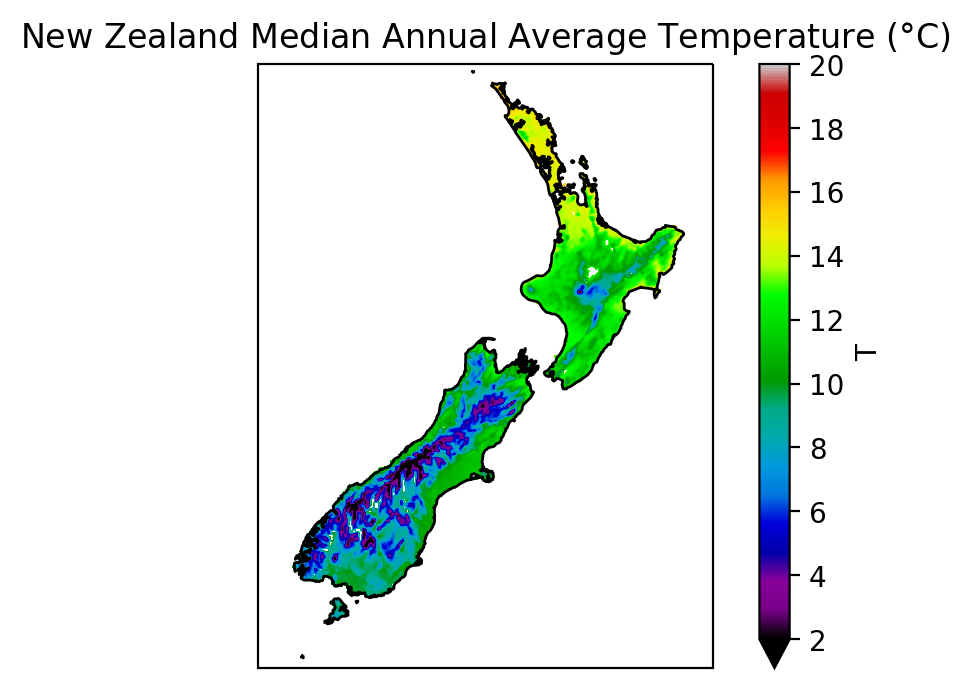

In [4]:
plot_dataset(median_annual_average_rainfall_nz, title=r"New Zealand Median Annual Average Temperature ($\degree$C)", vmin=2, vmax=20, cmap="nipy_spectral")

The Task also calls to replicate the Canterbury map as well. My methodology to do so includes:
1. download the geometry of the Canterbury region through LINZ data service API
2. create an mask (True in Canterbury, otherwise False) of the same dimensions of the national temperature dataset
3. apply the mask to the national dataset before calling the plot_dataset function

In [5]:
# The link to the dataset hosted online is: https://datafinder.stats.govt.nz/layer/104254-regional-council-2020-generalised/
# I use the requests package to query the LINZ DataService (using a API key so please don't share!) into a json object
res = requests.get("https://datafinder.stats.govt.nz/services/query/v1/vector.json?key=983eeb3faad9437388eee1b32af12bf7&layer=104254&x=172.33976723632992&y=-43.62574953992718&max_results=3&radius=10000&geometry=true&with_field_names=true")
# Create a GeoDataFrame by extracting the geometry from the json object
canterbury_boundary = gpd.GeoDataFrame.from_features(res.json()["vectorQuery"]["layers"]["104254"]["features"])
# When we go to plot, we will also need the lat/lon bounds (e.g. (168, 172, -46, -48)) to zoom the map to. However, they need to be in a specific order, and hence why values are swapped around
canterbury_bounds = canterbury_boundary.bounds.to_numpy().tolist()[0]
canterbury_bounds = (canterbury_bounds[0], canterbury_bounds[2], canterbury_bounds[1], canterbury_bounds[3])

In [10]:
# And now we shall create clipping mask, where an array is generated through the rasterio library. The inspiration behind this code is from: https://stackoverflow.com/questions/51398563/python-mask-netcdf-data-using-shapefile and https://gist.github.com/shoyer/0eb96fa8ab683ef078eb
# Firstly, we need to touchup the format of the coordinates so we can get the affline transform
coords = median_annual_average_rainfall_nz.coords
lat = np.asarray(coords["lat"]); lon = np.asarray(coords["lon"])
transform =  Affine.translation(lon[0], lat[0]) * Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
# And finally, we can use the rasterize function in rasterio to make the mask of True and False's
canterbury_mask = rasterize([(shape, True) for shape in canterbury_boundary.geometry], out_shape=(len(coords["lat"]), len(coords["lon"])), fill=False, transform=transform, dtype=float)

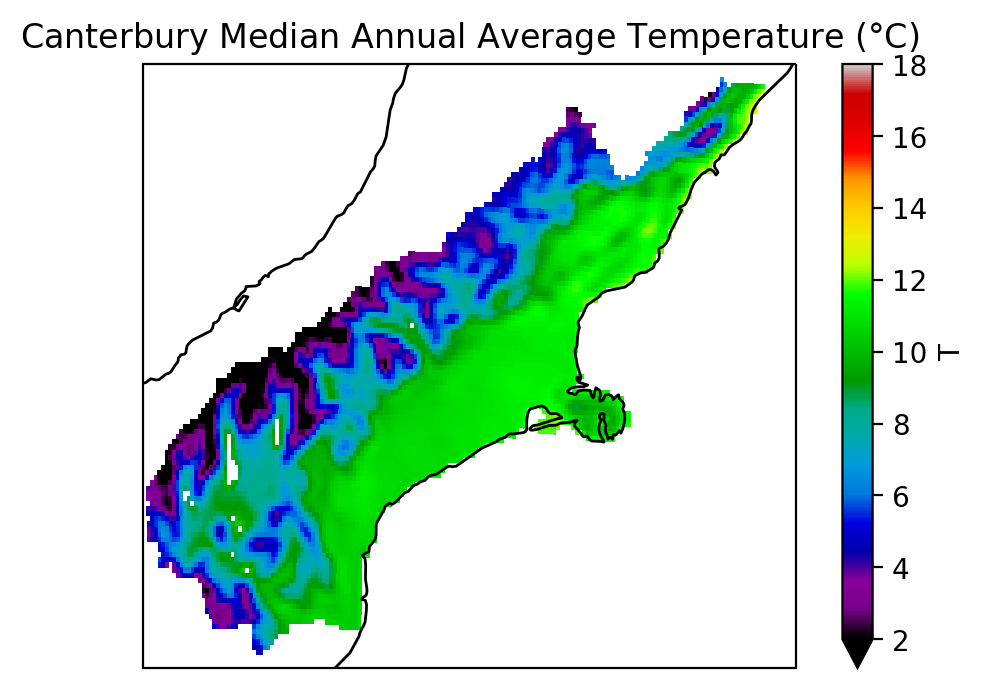

In [11]:
plot_dataset(median_annual_average_rainfall_nz.where(canterbury_mask), bounds=canterbury_bounds, title=r"Canterbury Median Annual Average Temperature ($\degree$C)", vmin=2, vmax=18, cmap="nipy_spectral")

### Task 4: Median annual total rainfall
Reproduce the median annual total rainnfall maps for both the New Zealand national scale and the Canterbury regional scale

Firstly, the rain datasets are store with the 'RAINNC' title. After optimising the code, the optimal computing time is when time is chunked into chunks of 75 units. The computation is straight-forward. The yearly sum of rainfall is firstly calculated by resampling the data into year categories and then summating all entries. After applying a mask of where New Zealand is, the median of these yearly categories can be computed. An estimated time for completion is approximately 16 minutes for the whole of New Zealand.

In [7]:
# Firstly, open the datasets in parallel and convert the data to yearly intervals and sum all enties to get each years cumulative rainfall
yearly_rain_nz_dataset = xr.open_mfdataset("/mnt/data/MetService_WRF/RAINNC_*", chunks={"time":75}, parallel=True).RAINNC.resample(time="1Y").sum(dim="time")
# Mask where the land is and then calculate the median for all the years given
with ProgressBar():
    median_yearly_rain_nz_dataset = yearly_rain_nz_dataset.where(nz_land_mask).median(dim="time").compute()

[########################################] | 100% Completed | 44min 15.4s


Using the function and canterbury variables established in the previous Task, the median annual total rainfall can be plotted for all of New Zealand and the Canterbury region.

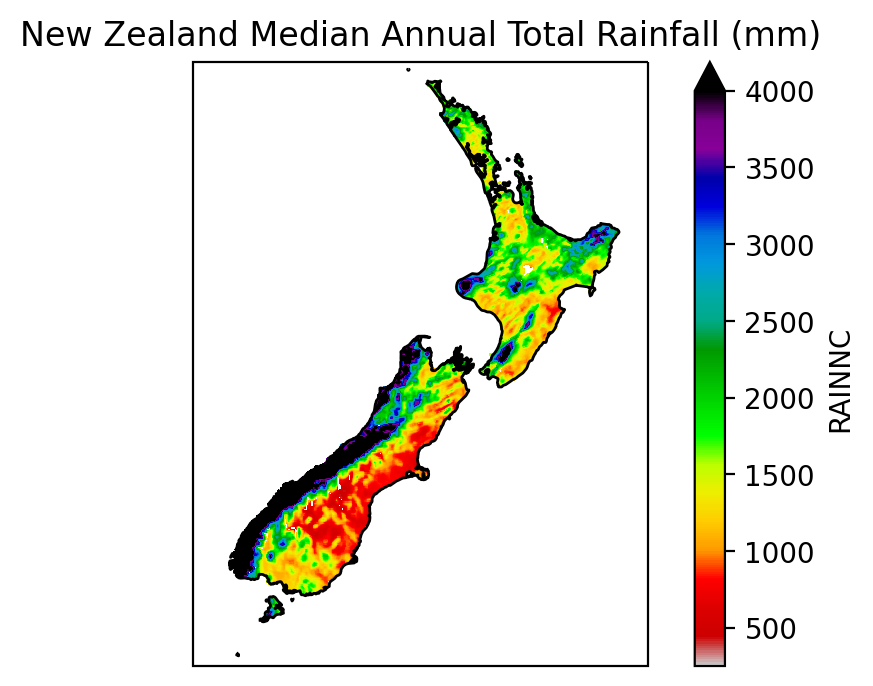

In [10]:
plot_dataset(median_yearly_rain_nz_dataset, title="New Zealand Median Annual Total Rainfall (mm)", vmin=250, vmax=4000, cmap="nipy_spectral_r")

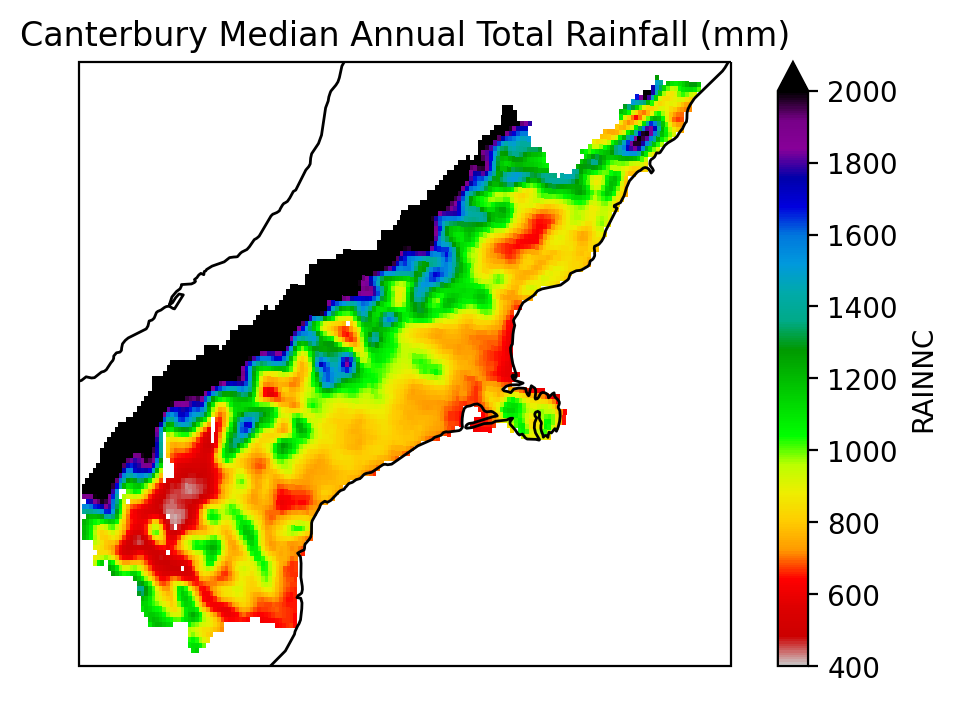

In [15]:
plot_dataset(median_yearly_rain_nz_dataset.where(canterbury_mask), title="Canterbury Median Annual Total Rainfall (mm)", bounds=canterbury_bounds, vmin=400, vmax=2000, cmap="nipy_spectral_r")